In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

import openml as oml

In [2]:
import utils
import metrics
import clustering_methods

## Dataset

**[Acute Inflammations Data Set](https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations)**  
The main idea of this data set is to prepare the algorithm of the expert system, which will perform the presumptive diagnosis of diseases of urinary system.
Acute inflammation of urinary bladder is characterised by sudden occurrence of pains in the abdomen region and the urination in form of constant urine pushing, micturition pains and sometimes lack of urine keeping. Temperature of the body is rising, however most often not above 38C. The excreted urine is turbid and sometimes bloody. At proper treatment, symptoms decay usually within several days. However, there is inclination to returns. At persons with acute inflammation of urinary bladder, we should expect that the illness will turn into protracted form.
Each instance represents an potential patient.

*Citation:*  J.Czerniak, H.Zarzycki, Application of rough sets in the presumptive diagnosis of urinary system diseases, Artifical Inteligence and Security in Computing Systems, ACS'2002 9th International Conference Proceedings, Kluwer Academic Publishers, 2003, pp. 41-51. https://doi.org/10.1007/978-1-4419-9226-0_5

In [3]:
dataset = oml.datasets.get_dataset(1556)

X, y, _, _ = dataset.get_data(
    dataset_format='dataframe',
    target=dataset.default_target_attribute
)

In [4]:
columns_rename = {'V1': 'Temperature of patient',
                  'V2': 'Occurrence of nausea',
                  'V3': 'Lumbar pain',
                  'V4': 'Urine pushing',
                  'V5': 'Micturition pains',
                  'V6': 'Burning of urethra, itch, swelling of urethra outlet'}

X.rename(columns_rename, axis=1, inplace=True)
X.replace({"no":0, "yes":1}, inplace=True)

In [5]:
y.name = 'Inflammation of urinary bladder'
y.replace({"no":0, "yes":1}, inplace=True)

In [6]:
X.head()

,Temperature of patient,Occurrence of nausea,Lumbar pain,Urine pushing,Micturition pains,"Burning of urethra, itch, swelling of urethra outlet"
0,35.5,0,1,0,0,0
1,35.9,0,0,1,1,1
2,35.9,0,1,0,0,0
3,36.0,0,0,1,1,1
4,36.0,0,1,0,0,0


In [7]:
y.head()

0    0
1    1
2    0
3    1
4    0
Name: Inflammation of urinary bladder, dtype: category
Categories (2, int64): [0 < 1]

## Modelling

In [8]:
xtrain, xtest, ytrain, ytest = sk.model_selection.train_test_split(X, y, random_state=2)

In [9]:
model = utils.fct_RF_gridsearch(xtrain, ytrain)

In [10]:
model.fit(xtrain.values, ytrain.values)

RandomForestClassifier(max_depth=2, n_estimators=200)

In [11]:
preds = model.predict(xtest.values)

In [12]:
model.score(xtest.values, ytest)

1.0

## Explanations

In [13]:
treeshap_influences = utils.TreeSHAP_oneclass(model, X)

In [14]:
kernelshap_influences = utils.KernelSHAP_oneclass(model, X)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


  0%|          | 0/120 [00:00<?, ?it/s]

In [15]:
lime_influences = utils.LIME_oneclass(model, X)[0]

## Clustering

In [16]:
list_percentages = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

With 120 patients in the dataset, the number of clusters will be as following :  
| Percentage  | 0.01 | 0.02 | 0.03 | 0.04 | 0.05 | 0.1 | 0.2 | 0.3 | 0.4 | 0.5 |
|-------------|:----:|:----:|:----:|:----:|:----:|:---:|:---:|:---:|:---:|:---:|
| Nb clusters |   2  |   2  |   4  |   5  |   6  |  12 |  24 |  36 |  48 |  60 |

In [17]:
raw_clusters = clustering_methods.cluster_multiple_percentage(X, list_percentages)
treeshap_clusters = clustering_methods.cluster_multiple_percentage(treeshap_influences, list_percentages)
kernelshap_clusters = clustering_methods.cluster_multiple_percentage(kernelshap_influences, list_percentages)
lime_clusters = clustering_methods.cluster_multiple_percentage(lime_influences, list_percentages)

Cluster 55 is empty! self.labels_[self.medoid_indices_[55]] may not be labeled with its corresponding cluster (55).
Cluster 56 is empty! self.labels_[self.medoid_indices_[56]] may not be labeled with its corresponding cluster (56).
Cluster 57 is empty! self.labels_[self.medoid_indices_[57]] may not be labeled with its corresponding cluster (57).
Cluster 58 is empty! self.labels_[self.medoid_indices_[58]] may not be labeled with its corresponding cluster (58).
Cluster 59 is empty! self.labels_[self.medoid_indices_[59]] may not be labeled with its corresponding cluster (59).


### Metrics

In [35]:
list_methods = ["Raw", "TreeSHAP", "KernelSHAP", "LIME"]

In [20]:
raw_metrics = {p:metrics.compute_clusters_purity_entropy(raw_clusters[p].labels_, y) for p in list_percentages}
treeshap_metrics = {p:metrics.compute_clusters_purity_entropy(treeshap_clusters[p].labels_, y) for p in list_percentages}
kernelshap_metrics = {p:metrics.compute_clusters_purity_entropy(kernelshap_clusters[p].labels_, y) for p in list_percentages}
lime_metrics = {p:metrics.compute_clusters_purity_entropy(lime_clusters[p].labels_, y) for p in list_percentages}

In [48]:
purity_metric = pd.DataFrame(columns = list_methods)
entropy_metric = pd.DataFrame(columns = list_methods)

for p in list_percentages :
    purity_metric.loc[p, "Raw"] = raw_metrics[p][0]
    purity_metric.loc[p, "TreeSHAP"] = treeshap_metrics[p][0]
    purity_metric.loc[p, "KernelSHAP"] = kernelshap_metrics[p][0]
    purity_metric.loc[p, "LIME"] = lime_metrics[p][0]
    
    entropy_metric.loc[p, "Raw"] = raw_metrics[p][1]
    entropy_metric.loc[p, "TreeSHAP"] = treeshap_metrics[p][1]
    entropy_metric.loc[p, "KernelSHAP"] = kernelshap_metrics[p][1]
    entropy_metric.loc[p, "LIME"] = lime_metrics[p][1]

In [50]:
display(purity_metric)
display(entropy_metric)

,Raw,TreeSHAP,KernelSHAP,LIME
0.01,0.333333,0.491667,0.491667,0.491667
0.02,0.333333,0.491667,0.491667,0.491667
0.03,0.658333,0.758333,0.758333,0.758333
0.04,0.725,0.833333,0.916667,0.833333
0.05,0.691667,0.916667,0.916667,0.916667
0.10,0.916667,0.933333,0.933333,0.916667
0.20,0.966667,0.991667,0.983333,0.975
0.30,0.975,0.95,0.983333,0.966667
0.40,0.983333,0.991667,0.991667,0.991667
0.50,0.991667,0.991667,0.991667,0.991667


,Raw,TreeSHAP,KernelSHAP,LIME
0.01,0.55387,0.0,0.0,0.061146
0.02,0.55387,0.0,0.0,0.061146
0.03,0.49969,0.234351,0.234351,0.234351
0.04,0.447615,0.234351,0.0,0.234351
0.05,0.398769,0.0,0.0,0.0
0.10,0.0,0.0,0.0,0.0
0.20,0.0,0.0,0.0,0.0
0.30,0.0,0.0,0.0,0.0
0.40,0.0,0.0,0.0,0.0
0.50,0.0,0.0,0.0,0.0


### Graphics

In [72]:
markers = ['s-r', 'p-k', 'o-b', '*-g']

<Axes: title={'center': 'Purity of clustering based on the percentage of clusters selected'}, xlabel='Percentages of clusters', ylabel='Purity'>

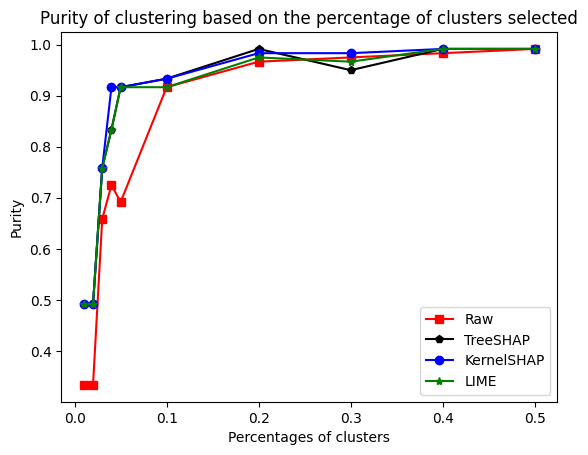

In [74]:
purity_metric.plot.line(style=markers,
                        title='Purity of clustering based on the percentage of clusters selected', 
                        xlabel='Percentages of clusters', ylabel='Purity')

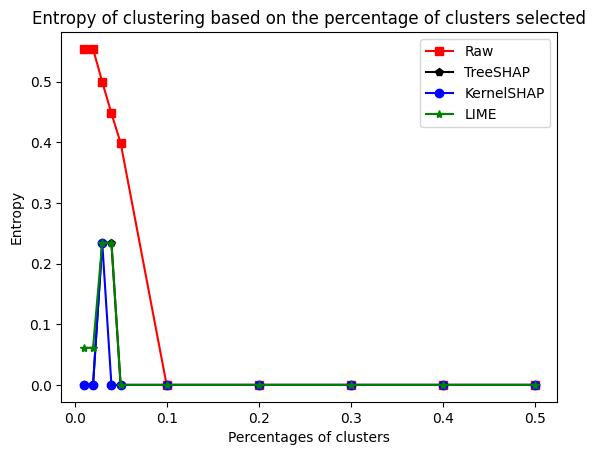

In [94]:
entropy_metric.plot.line(style=markers,
                        title='Entropy of clustering based on the percentage of clusters selected', 
                        xlabel='Percentages of clusters', ylabel='Entropy')
plt.show()